In [1]:
import os
import shutil
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from logger import logger
%matplotlib inline

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

import numpy as np
import warnings

from keras.preprocessing import image
from keras.layers import merge, Input
from keras.layers import Dense, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from imagenet_utils import decode_predictions, preprocess_input

Using Theano backend.


In [3]:
# current_dir = '../data/images/train'
# new_dir = '../data/images/all_images'

### Create top level category dir

In [3]:
train_dir = '../data/images_sample/train/'
train_top_level_dir = '../data/images_sample/train/'
train_top_level_dir = '../data/images_sample/train_top_level/'

In [417]:
top_level_dict = dict()

for image_dir in os.listdir(train_dir):
    if not image_dir.startswith('.'):
        top_level_category = image_dir.split('->')[0].strip()
        try:
            top_level_dict[top_level_category] += 1
        except:
            top_level_dict[top_level_category] = 1

In [418]:
for top_level_category in top_level_dict.keys():
    try:
        os.makedirs(os.path.join(train_top_level_dir, top_level_category))
    except OSError:
        logger.info('{} already exists in {}'.format(top_level_category, train_top_level_dir))

2016-12-25 14:09:20,410 - Toys & Games already exists in ../data/images_sample/train_top_level/
2016-12-25 14:09:20,411 - Home & Kitchen already exists in ../data/images_sample/train_top_level/
2016-12-25 14:09:20,412 - Clothing, Shoes & Jewelry already exists in ../data/images_sample/train_top_level/
2016-12-25 14:09:20,413 - Cell Phones & Accessories already exists in ../data/images_sample/train_top_level/


### Copy  to top level category directory

In [54]:
images_copied = 0

for image_dir in os.listdir(train_dir):
    if not image_dir.startswith('.'):
        image_paths = os.listdir(os.path.join(train_dir, image_dir))
        image_count = len(image_paths)
        top_level_image_dir = image_dir.split('->')[0].strip()
        print image_dir, '|', top_level_image_dir
        
        for image in image_paths:
            if not image.startswith('.'):
                original_image_path = os.path.join(train_dir, image_dir, image)
                new_image_path = os.path.join(train_top_level_dir, top_level_image_dir, image)
                shutil.copy(original_image_path, new_image_path)
        
        images_copied += image_count
        logger.info('{} images copied so far'.format(images_copied))

2016-12-25 12:09:13,551 - 37 images copied so far
2016-12-25 12:09:13,597 - 74 images copied so far
2016-12-25 12:09:13,685 - 123 images copied so far


Cell Phones & Accessories -> Accessories -> Headsets -> Bluetooth Headsets | Cell Phones & Accessories
Clothing, Shoes & Jewelry -> Men -> Shoes -> Fashion Sneakers | Clothing, Shoes & Jewelry
Home & Kitchen -> Bath -> Bath Rugs | Home & Kitchen
Toys & Games -> Tricycles, Scooters & Wagons -> Ride-On Toys | Toys & Games


2016-12-25 12:09:13,739 - 176 images copied so far


### Count total number of images

In [15]:
image_count_total = 0

for image_dir in os.listdir(train_top_level_dir):
    if not image_dir.startswith('.'):
        image_names = os.listdir(os.path.join(train_top_level_dir, image_dir))
        image_names = [image_name for image_name in image_names if not image_name.startswith('.')]
        image_count = len(image_names)
        print image_dir, image_count
        image_count_total += image_count

Cell Phones & Accessories 36
Clothing, Shoes & Jewelry 36
Home & Kitchen 48
Toys & Games 52


In [17]:
image_count_total

172

### Create index to image.jpeg dict

In [419]:
all_image_names = list()

for image_dir in os.listdir(train_top_level_dir):
    if not image_dir.startswith('.'):
        image_names = os.listdir(os.path.join(train_top_level_dir, image_dir))
        
        for image_name in image_names:
            if not image_name.startswith('.'):
                all_image_names.append(os.path.join(train_top_level_dir, image_dir, image_name))

In [420]:
idx_to_image_dict = dict()

for i, image_name in enumerate(all_image_names):
    idx_to_image_dict[i] = image_name

In [583]:
idx_to_image_dict

{0: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KBZEOBU.jpg',
 1: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KCFPKY4.jpg',
 2: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KCLOFQ2.jpg',
 3: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KCLSY64.jpg',
 4: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KD15484.jpg',
 5: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KD7KPZK.jpg',
 6: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KERDISU.jpg',
 7: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KFW3NUW.jpg',
 8: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KFZ5WUS.jpg',
 9: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KG0X1DW.jpg',
 10: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KH7ZZ9C.jpg',
 11: '../data/images_sample/train_top_level/Cell Phon

### Create category to int dict

In [50]:
category_to_int_dict = dict()
idx = 0

for image_dir in os.listdir(train_top_level_dir):
    if not image_dir.startswith('.'):
        image_names = os.listdir(os.path.join(train_top_level_dir, image_dir))
        image_names = [image_name for image_name in image_names if not image_name.startswith('.')]
        image_count = len(image_names)
        
        category_to_int_dict[image_dir] = (idx, image_count)
        idx += 1

In [138]:
# category_to_int_dict = dict()
# idx = 0

# for image_dir in os.listdir(train_top_level_dir):
#     if not image_dir.startswith('.'):
#         image_names = os.listdir(os.path.join(train_top_level_dir, image_dir))
#         image_names = [image_name for image_name in image_names if not image_name.startswith('.')]
#         image_count = len(image_names)
        
#         category_to_int_dict[image_dir] = image_count

# top_level_set = set()

# for key, value in category_to_int_dict.iteritems():
#     top_level_category = key.split('->')[0].strip()
#     top_level_set.add(top_level_category)

# top_level_set

# top_level_count_dict = dict()

# for top_level in top_level_set:
#     top_level_count_dict[top_level] = 0

# top_level_count_dict

# for image_dir in os.listdir(train_top_level_dir):
#     if not image_dir.startswith('.'):
#         top_level_category = image_dir.split('->')[0].strip()
        
#         image_names = os.listdir(os.path.join(train_top_level_dir, image_dir))
#         image_names = [image_name for image_name in image_names if not image_name.startswith('.')]
#         image_count = len(image_names)
        
#         top_level_count_dict[top_level_category] += image_count

# print top_level_count_dict

# print sum([val for val in top_level_count_dict.values()])

# import operator

# category_to_int_dict_sorted = sorted(category_to_int_dict.items(), key=operator.itemgetter(1), reverse=True)

# print category_to_int_dict_sorted

In [115]:
category_labels = list(itertools.chain.from_iterable([tup[0]] * tup[1] for tup in category_to_int_dict.values()))

TypeError: 'int' object has no attribute '__getitem__'

In [482]:
# Reverse labels as category_to_int_dict.values() returns values from the last category
category_labels.reverse()

In [484]:
# category_labels

### Create top level index to image.jpeg dict

In [600]:
top_level_idx_to_image_dict = dict()

In [609]:
top_level_idx_to_image_dict = dict()

for image_dir in os.listdir(train_top_level_dir):
    if not image_dir.startswith('.'):
        image_dir_idx = category_to_int_dict[image_dir][0]
        print image_dir, image_dir_idx
        
        top_level_idx_to_image_dict[image_dir_idx] = dict()
        image_idx = 0

        image_names = os.listdir(os.path.join(train_top_level_dir, image_dir))
        
        for image_name in image_names:
            if not image_name.startswith('.'):
                image_path = os.path.join(train_top_level_dir, image_dir, image_name)
                top_level_idx_to_image_dict[image_dir_idx][image_idx] = image_path
                image_idx += 1

Cell Phones & Accessories 0
Clothing, Shoes & Jewelry 1
Home & Kitchen 2
Toys & Games 3


In [610]:
top_level_idx_to_image_dict

{0: {0: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KBZEOBU.jpg',
  1: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KCFPKY4.jpg',
  2: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KCLOFQ2.jpg',
  3: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KCLSY64.jpg',
  4: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KD15484.jpg',
  5: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KD7KPZK.jpg',
  6: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KERDISU.jpg',
  7: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KFW3NUW.jpg',
  8: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KFZ5WUS.jpg',
  9: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KG0X1DW.jpg',
  10: '../data/images_sample/train_top_level/Cell Phones & Accessories/B00KH7ZZ9C.jpg',
  11: '../data/images_sample/train_top_

### Create bottleneck features

In [682]:
train_dir = '../data/images_sample/train_top_level/'
train_dir_above = '../data/images_sample/'

In [738]:
image_count = len(category_labels)
img_width = 299
img_height = 299

In [739]:
image_count

172

In [740]:
def largest_divisor(n, threshold=100):
    factors_set = set(reduce(list.__add__, ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))
    factors_list = [i for i in factors_set if i <= threshold]
    factors_list.sort()
    return factors_list[-1]

In [741]:
# Load Data Genenerator
def load_data_generator():
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen

In [742]:
datagen = load_data_generator()

In [743]:
generator = datagen.flow_from_directory(train_dir, 
                                        target_size=(img_width, img_height), 
                                        batch_size=largest_divisor(image_count), 
                                        class_mode=None, 
                                        shuffle=False, 
                                        seed=1368)

Found 172 images belonging to 4 classes.


In [744]:
# model = ResNet50(include_top=False, weights='imagenet', input_tensor=None)
model = InceptionV3(include_top=False, weights='imagenet', input_tensor=None)
# model = VGG16(include_top=False, weights='imagenet', input_tensor=None)

In [745]:
bottleneck_feats = model.predict_generator(generator, val_samples=generator.N, max_q_size=20, nb_worker=1)
np.save(open(train_dir_above + 'model/' + 'bottleneck_features.npy', 'w'), bottleneck_feats)

In [569]:
# bottleneck_feats = np.load(open('../data/images_sample/model/bottleneck_features.npy'))

In [747]:
bottleneck_feats.shape

(172, 2048)

### To Do
- How to featurize new search image and calculate cosine similiarity?
- How to filter by category?

### Process search image and find similar

In [1011]:
def cosine_similarity(bottleneck_features):
    csim = bottleneck_features.dot(bottleneck_features.T)
    if not isinstance(csim, np.ndarray):
        csim = csim.toarray()
    norms = np.array([np.sqrt(np.diagonal(csim))])
    return (csim / norms / norms.T)

In [1012]:
search_image_dir_path = '../data/images_sample/search_image/'
search_images = os.listdir(search_image_dir_path)
search_images = [search_image for search_image in search_images if not search_image.startswith('.')]
search_image_path = os.path.join(search_image_dir_path, search_image)

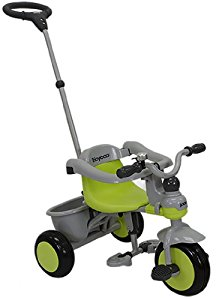

In [1013]:
Image(search_image_path)

In [1014]:
search_image = image.load_img(search_image_path, target_size=(299, 299))
search_image = image.img_to_array(search_image)
search_image = np.multiply(search_image, 1. / 255)
search_image = np.expand_dims(search_image, axis=0)

In [1015]:
search_image_features = model.predict(search_image)

In [1016]:
search_image_features

array([[ 1.23420906, -0.25669402, -0.62023628, ..., -0.16175544,
         0.09546103, -0.24230234]], dtype=float32)

In [1017]:
search_image_features

array([[ 1.23420906, -0.25669402, -0.62023628, ..., -0.16175544,
         0.09546103, -0.24230234]], dtype=float32)

In [1018]:
search_image_features

array([[ 1.23420906, -0.25669402, -0.62023628, ..., -0.16175544,
         0.09546103, -0.24230234]], dtype=float32)

In [1019]:
search_filter = -1

In [1020]:
# Add category labels to bottleneck_feats
bottleneck_feats = np.load(open('../data/images_sample/model/bottleneck_features.npy'))
bottleneck_feats = np.insert(bottleneck_feats, 0, category_labels, axis=1)

In [1021]:
if search_filter == -1:
    bottleneck_feats = bottleneck_feats[:, 1:]
else:
    bottleneck_filter = bottleneck_feats[:, 0] == search_filter
    bottleneck_feats = bottleneck_feats[bottleneck_filter, 1:]

In [1022]:
combined_features = np.vstack([search_image_features, bottleneck_feats])

In [1023]:
csim = cosine_similarity(combined_features)

In [1024]:
csim[0]

array([  1.00000012e+00,  -2.84976121e-02,   1.42377168e-01,
        -4.81601618e-02,  -2.48492658e-02,   3.40107456e-02,
         1.16062634e-01,   6.59521520e-02,   7.91512504e-02,
         2.38767806e-02,   2.75557977e-03,   3.50067094e-02,
        -1.72784746e-01,  -7.45880902e-02,  -3.18800211e-02,
         3.99638116e-02,  -1.04719857e-02,   1.65823206e-01,
         1.82255790e-01,   1.24460697e-01,   8.81371200e-02,
         1.95971169e-02,   4.78085550e-03,  -1.70652997e-02,
         7.02306554e-02,   7.25716678e-03,   2.70743575e-03,
         3.42497751e-02,   5.42605706e-02,   9.32259485e-02,
         2.14953810e-01,   9.83590111e-02,   5.99940978e-02,
         8.09543654e-02,   1.76114529e-01,   1.13067426e-01,
         1.21502846e-01,   4.35910076e-02,   5.88439172e-04,
         4.70955819e-02,   3.54670249e-02,   3.91340144e-02,
         6.43013939e-02,  -5.24289198e-02,  -4.84481566e-02,
         5.02028465e-02,   5.56604229e-02,   1.04688831e-01,
         6.84339926e-02,

In [1025]:
similarity_threshold = 0.58

most_similar = np.argsort(-csim[0])[:10]

# Exclude similar images below a certain similarity threshold
most_similar = [idx for idx in most_similar if csim[0, idx] > similarity_threshold]

# Exclude search image where idx = 0
most_similar = [idx - 1 for idx in most_similar if idx != 0]

[168, 166, 158]
../data/images_sample/train_top_level/Toys & Games/B00J6BIYRU.jpg
../data/images_sample/train_top_level/Toys & Games/B00IYX1VXK.jpg
../data/images_sample/train_top_level/Toys & Games/B00II5G67K.jpg


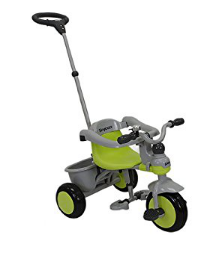

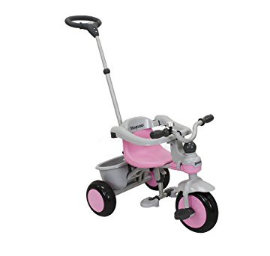

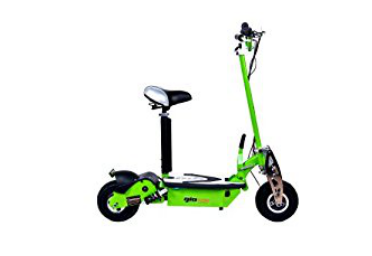

In [1026]:
print most_similar

if search_filter == -1:
    image_lookup_dict = idx_to_image_dict
else:
    image_lookup_dict = top_level_idx_to_image_dict[search_filter]

for i in most_similar:
    image_path = image_lookup_dict[i]
    print image_path
    image_display = plt.imread(image_path)
    plt.axis('off')
    plt.imshow(image_display.astype('uint8'))
    plt.figure()

### Resnet model

In [679]:
TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x


def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None):
    '''Instantiate the ResNet50 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. xput of `layers.Input()`)
            to use as image input for the model.

    # Returns
        A Keras model instance.
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 224, 224)
        else:
            input_shape = (3, 224, 224)
    else:
        if include_top:
            input_shape = (224, 224, 3)
        else:
            input_shape = (224, 224, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)
    
    x = Flatten()(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(1000, activation='softmax', name='fc1000')(x)

    model = Model(img_input, x)

    # load weights
    if weights == 'imagenet':
        print('K.image_dim_ordering:', K.image_dim_ordering())
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('resnet50_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='1c1f8f5b0c8ee28fe9d950625a230e1c')
            else:
                weights_path = get_file('resnet50_weights_th_dim_ordering_th_kernels_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='f64f049c92468c9affcd44b0976cdafe')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
            else:
                weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='a268eb855778b3df3c7506639542a6af')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model

In [737]:
TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_th_dim_ordering_th_kernels.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


def conv2d_bn(x, nb_filter, nb_row, nb_col,
              border_mode='same', subsample=(1, 1),
              name=None):
    '''
    Utility function to apply conv + BN.
    '''
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_dim_ordering() == 'th':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample,
                      activation='relu',
                      border_mode=border_mode,
                      name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name)(x)
    return x


def InceptionV3(include_top=True, weights='imagenet',
                input_tensor=None):
    '''Instantiate the Inception v3 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    Note that the default input image size for this model is 299x299.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.

    # Returns
        A Keras model instance.
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 299, 299)
        else:
            input_shape = (3, 299, 299)
    else:
        if include_top:
            input_shape = (299, 299, 3)
        else:
            input_shape = (299, 299, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor

    if K.image_dim_ordering() == 'th':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, subsample=(2, 2), border_mode='valid')
    # with stride=2 border='valid', output becomes (299-1)/2 = 149 x 149
    x = conv2d_bn(x, 32, 3, 3, border_mode='valid')  # 149 - 2 = 147 x 147
    x = conv2d_bn(x, 64, 3, 3)  # 147 x 147
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # 49

    x = conv2d_bn(x, 80, 1, 1, border_mode='valid')
    x = conv2d_bn(x, 192, 3, 3, border_mode='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    for i in range(3):
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
        x = merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(i))

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, subsample=(2, 2), border_mode='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3,
                             subsample=(2, 2), border_mode='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = merge([branch3x3, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 160, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          subsample=(2, 2), border_mode='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3,
                            subsample=(2, 2), border_mode='valid')

    branch_pool = AveragePooling2D((3, 3), strides=(2, 2))(x)
    x = merge([branch3x3, branch7x7x3, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = merge([branch3x3_1, branch3x3_2],
                          mode='concat', concat_axis=channel_axis,
                          name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = merge([branch3x3dbl_1, branch3x3dbl_2],
                             mode='concat', concat_axis=channel_axis)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = merge([branch1x1, branch3x3, branch3x3dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(9 + i))

    x = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)  # Moved here for transfer learning
    
    x = Flatten(name='flatten')(x)

    if include_top:
        # Classification block
        # x = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)
        # x = Flatten(name='flatten')(x)
        x = Dense(1000, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(img_input, x)

    # load weights
    if weights == 'imagenet':
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('inception_v3_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='b3baf3070cc4bf476d43a2ea61b0ca5f')
            else:
                weights_path = get_file('inception_v3_weights_th_dim_ordering_th_kernels_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='79aaa90ab4372b4593ba3df64e142f05')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='fe114b3ff2ea4bf891e9353d1bbfb32f')
            else:
                weights_path = get_file('inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='2f3609166de1d967d1a481094754f691')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model

In [681]:
TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16(include_top=True, weights='imagenet',
          input_tensor=None):
    '''Instantiate the VGG16 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.

    # Returns
        A Keras model instance.
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 224, 224)
        else:
            input_shape = (3, 224, 224)
    else:
        if include_top:
            input_shape = (224, 224, 3)
        else:
            input_shape = (224, 224, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor

    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Flatten(name='flatten')(x)  # Add flattern

    if include_top:
        # Classification block
        # x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(1000, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(img_input, x)

    # load weights
    if weights == 'imagenet':
        print('K.image_dim_ordering:', K.image_dim_ordering())
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model

### Understanding InceptionV3 architecture

In [ ]:
from keras.models import Sequential

In [ ]:
def conv2d_bn(x, nb_filter, nb_row, nb_col,
              border_mode='same', subsample=(1, 1),
              name=None):
    '''
    Utility function to apply conv + BN.
    '''
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_dim_ordering() == 'th':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample,
                      activation='relu',
                      border_mode=border_mode,
                      name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name)(x)
    return x



In [ ]:
img_input = Input(shape=(3, 299, 299))

In [ ]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, subsample=(2, 2), border_mode='valid', input_shape=(3, 299, 299)))
model.output_shape

In [ ]:
model.add(Convolution2D(32, 3, 3, border_mode='valid'))
model.output_shape

In [ ]:
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.output_shape

In [ ]:
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.output_shape

In [ ]:
model.add(Convolution2D(80, 1, 1, border_mode='valid'))
model.output_shape

In [ ]:
model.add(Convolution2D(192, 3, 3, border_mode='valid'))
model.output_shape

In [ ]:
model.add(MaxPooling2D((3, 3), strides=(2, 2)))
model.output_shape

In [ ]:
x = conv2d_bn(img_input, 32, 3, 3, subsample=(2, 2), border_mode='valid')
# with stride=2 border='valid', output becomes (299-1)/2 = 149 x 149
x = conv2d_bn(x, 32, 3, 3, border_mode='valid')  # 149 - 2 = 147 x 147
x = conv2d_bn(x, 64, 3, 3)  # 147 x 147
x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # 49

x = conv2d_bn(x, 80, 1, 1, border_mode='valid')
x = conv2d_bn(x, 192, 3, 3, border_mode='valid')
x = MaxPooling2D((3, 3), strides=(2, 2))(x)